In [2]:
import temporian as tp
import numpy as np
import pandas as pd

In [47]:
from pathlib import Path
data_dir = Path("~/Downloads") / "child-mind-institute-detect-sleep-states"

# Dataframe with events
df_ev = pd.read_csv(data_dir / "train_events.csv")[["series_id", "event", "timestamp"]]
df_ev

,series_id,event,timestamp
0,038441c925bb,onset,2018-08-14T22:26:00-0400
1,038441c925bb,wakeup,2018-08-15T06:41:00-0400
2,038441c925bb,onset,2018-08-15T19:37:00-0400
3,038441c925bb,wakeup,2018-08-16T05:41:00-0400
4,038441c925bb,onset,2018-08-16T23:03:00-0400
...,...,...,...
14503,fe90110788d2,wakeup,2017-09-06T04:07:00-0400
14504,fe90110788d2,onset,2017-09-06T23:35:00-0400
14505,fe90110788d2,wakeup,2017-09-07T09:17:00-0400
14506,fe90110788d2,onset,NaN


In [48]:
# Dataframe with signals
df_sig = pd.read_parquet(data_dir / "train_series.parquet", columns=["series_id", "timestamp", "anglez"])

In [49]:
df_sig

,series_id,timestamp,anglez
0,038441c925bb,2018-08-14T15:30:00-0400,2.636700
1,038441c925bb,2018-08-14T15:30:05-0400,2.636800
2,038441c925bb,2018-08-14T15:30:10-0400,2.637000
3,038441c925bb,2018-08-14T15:30:15-0400,2.636800
4,038441c925bb,2018-08-14T15:30:20-0400,2.636800
...,...,...,...
127946335,fe90110788d2,2017-09-08T00:14:35-0400,-27.277500
127946336,fe90110788d2,2017-09-08T00:14:40-0400,-27.032499
127946337,fe90110788d2,2017-09-08T00:14:45-0400,-26.841200
127946338,fe90110788d2,2017-09-08T00:14:50-0400,-26.723900


In [50]:
# Filter data to use in the example
ids = df_ev["series_id"].unique()[:10]

df_events = df_ev[df_ev["series_id"].isin(ids) & df_ev["timestamp"].notnull()]
df_signals = df_sig[df_sig["series_id"].isin(ids) & df_sig["timestamp"].notnull()]

In [51]:
df_events

,series_id,event,timestamp
0,038441c925bb,onset,2018-08-14T22:26:00-0400
1,038441c925bb,wakeup,2018-08-15T06:41:00-0400
2,038441c925bb,onset,2018-08-15T19:37:00-0400
3,038441c925bb,wakeup,2018-08-16T05:41:00-0400
4,038441c925bb,onset,2018-08-16T23:03:00-0400
...,...,...,...
485,0cd1e3d0ed95,wakeup,2017-12-12T06:32:00-0500
486,0cd1e3d0ed95,onset,2017-12-12T22:44:00-0500
487,0cd1e3d0ed95,wakeup,2017-12-13T06:44:00-0500
502,0cd1e3d0ed95,onset,2017-12-20T21:37:00-0500


In [20]:
df_signals

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
4838215,0cd1e3d0ed95,370255,2017-12-30T01:14:35-0500,11.444400,0.0152
4838216,0cd1e3d0ed95,370256,2017-12-30T01:14:40-0500,11.441600,0.0153
4838217,0cd1e3d0ed95,370257,2017-12-30T01:14:45-0500,11.463000,0.0153
4838218,0cd1e3d0ed95,370258,2017-12-30T01:14:50-0500,11.476700,0.0152


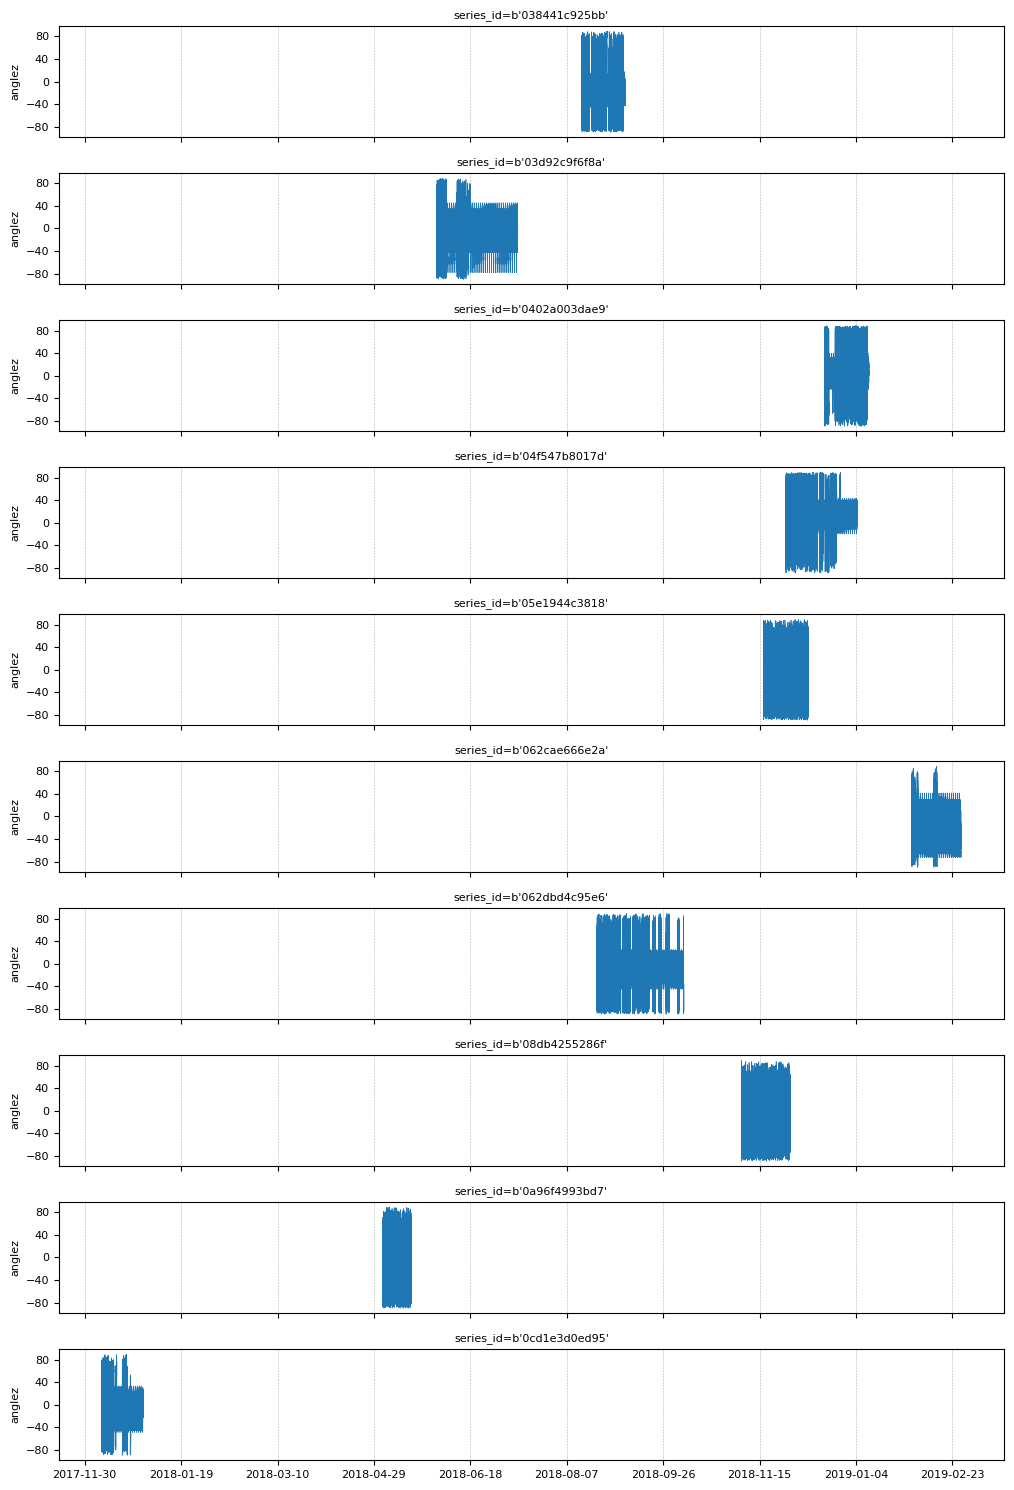

In [22]:
sig_evset = tp.from_pandas(df_signals[["series_id", "timestamp", "anglez"]], indexes=["series_id"])
sig_evset.plot()

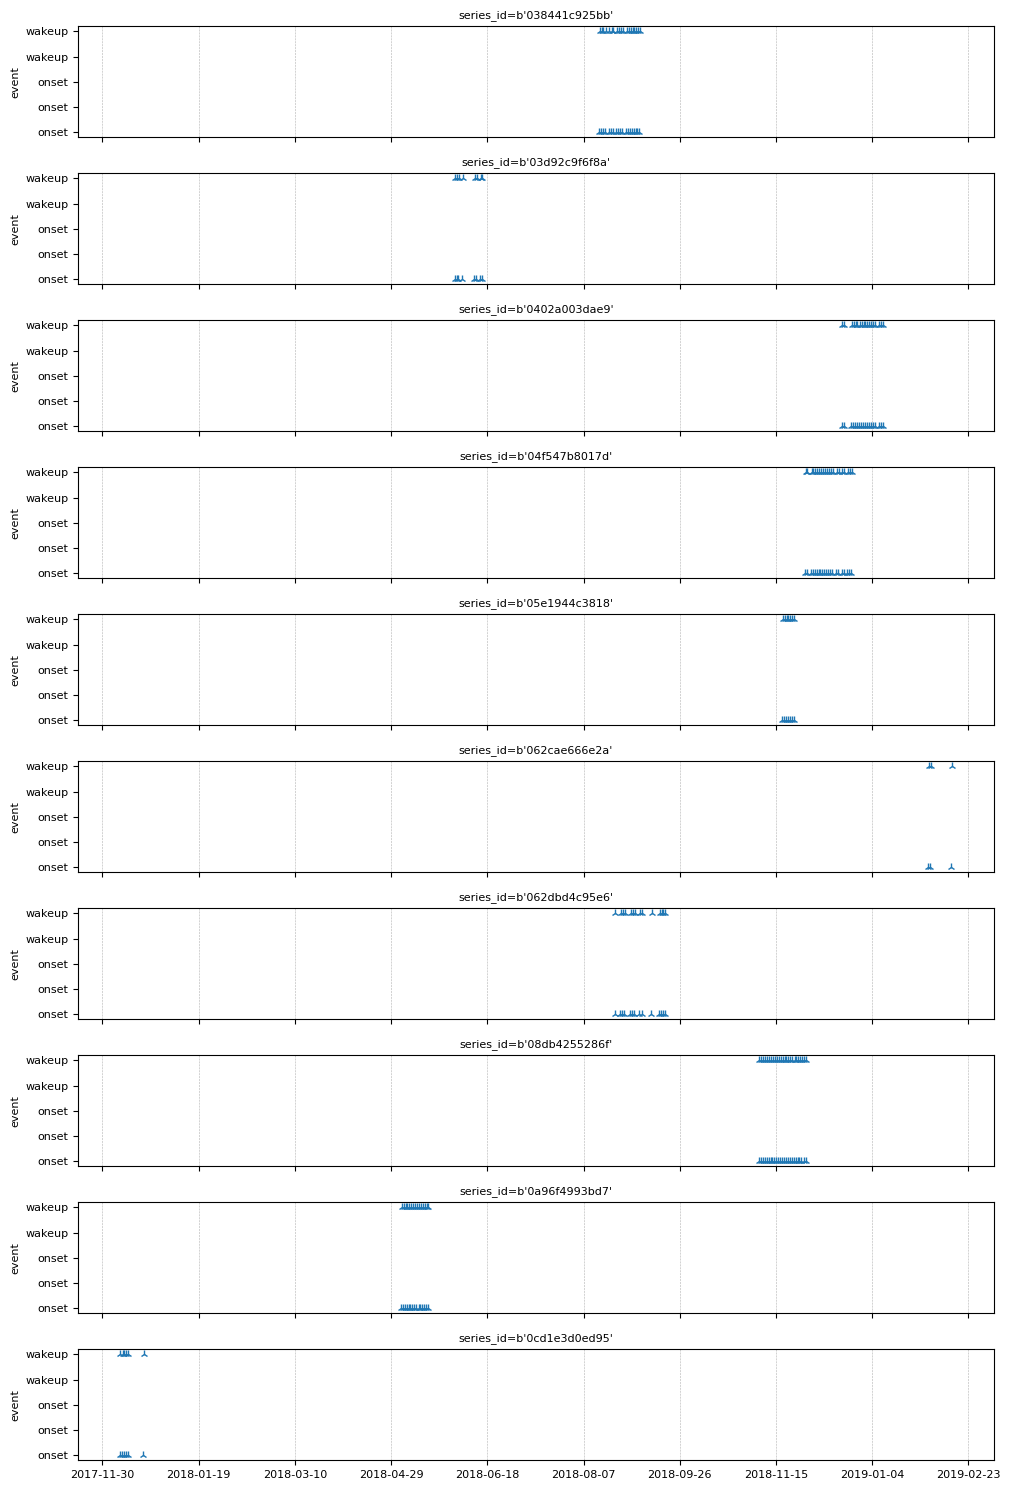

In [23]:
events_evset = tp.from_pandas(df_events[["series_id", "event", "timestamp"]], indexes=["series_id"])
events_evset.plot()

In [40]:
onset = events_evset.filter(events_evset["event"].equal("onset"))
wakeup = events_evset.filter(events_evset["event"].equal("wakeup"))

In [42]:
sleeping_windows = onset.since_last(sampling=wakeup)

In [62]:
avg_per_sleep = sig_evset.simple_moving_average(window_length=sleeping_windows)
std_per_sleep = sig_evset.moving_standard_deviation(window_length=sleeping_windows)

sleep_metrics = tp.glue(avg_per_sleep.prefix("avg_"), std_per_sleep.prefix("std_"))

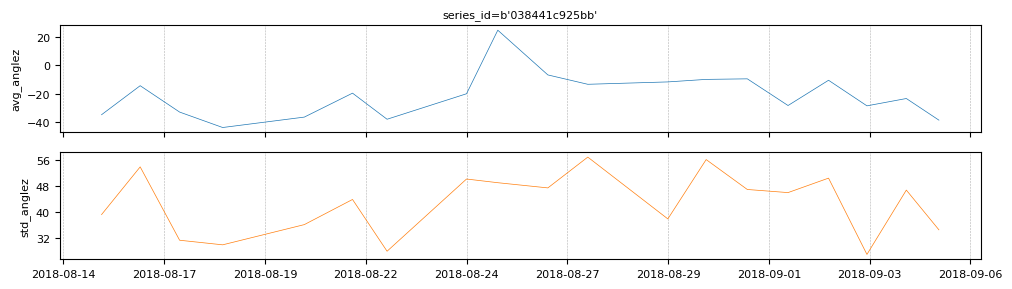

In [86]:
sleep_metrics.plot(indexes=["038441c925bb"], style='line')

### Pandas

In [79]:
df_combined = pd.concat([df_events, df_signals])

df_combined = df_combined.sort_values(by=["series_id", "timestamp"])

df_combined["night_id"] = (df_combined["event"] == "onset").cumsum()

df_signal_nn = df_combined[df_combined["anglez"].notnull()]

df_means = df_signal_nn.groupby(["series_id", "night_id"]).aggregate({"anglez": "mean", "timestamp": "max"})
df_means

anglez                 timestamp
series_id    night_id                                     
038441c925bb 0        -16.453644  2018-08-14T22:25:55-0400
             1        -17.651525  2018-08-15T19:36:55-0400
             2        -10.262909  2018-08-16T23:02:55-0400
             3        -17.138945  2018-08-17T22:59:55-0400
             4        -13.018537  2018-08-19T22:17:55-0400
...                          ...                       ...
0cd1e3d0ed95 132      -14.903581  2017-12-10T19:32:55-0500
             133      -10.314126  2017-12-11T21:47:55-0500
             134        3.612197  2017-12-12T22:43:55-0500
             135       -9.537580  2017-12-20T21:36:55-0500
             136       -8.302961  2017-12-30T01:14:55-0500

[146 rows x 2 columns]

<Axes: xlabel='timestamp'>

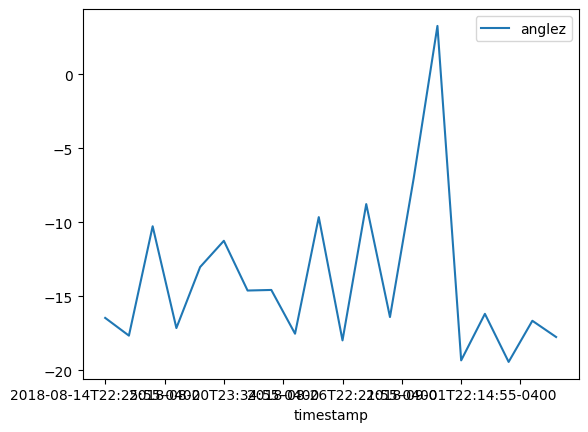

In [85]:
df_plain = df_means.reset_index()
df_series = df_plain[df_plain["series_id"] == "038441c925bb"]
df_series.plot(x="timestamp", y="anglez")